# **Aprendizaje Automático para Machine Learning**

## Actividad individual 2: "PERCEPTRON"

Fabio Santamaría Iglesias

21/07/2021

# **Introducción**

El objetivo de esta actividad consiste en construir un perceptrón. Lo aplicaremos a un *dataset* de puntos bidimensionales agrupados en dos clusters diferenciados por una etiqueta. De esta forma, nuestra neurona aprenderá a clasificar nuevos puntos en base a su posición.

Primeramente, importamos las librerías comunes que vamos a usar:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# **Obtenición del dataset**

A continuación, generamos un *dataset* compuesto por 2000 puntos bidimensionales. Cada punto tiene una etiqueta con dos valores posibles. Buscamos aplicar nuestro perceptrón para predecir el valor de la etiqueta de un punto en función de sus coordenadas bidimensionales. Por ello, nuestro problema solo puede ser resuelto si los puntos se hallan formando clusters según el valor de su etiqueta.

Para crear un *dataset* con las características mencionadas usamos la librería *make_blobs*:

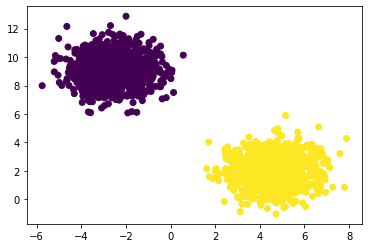

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=2000, random_state=42, n_features=2, centers=2)
plt.scatter(x=X[:,0], y=X[:,1], c=y)
plt.show()

A continuación, dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%):

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 2) (1600,)
(400, 2) (400,)


# **Perceptrón**

El perceptrón unicapa, con una única neurona, se compone de tantos pesos como características tengan nuestros datos. Adicionalmente, se introduce un peso a mayores, denominado bias. 

Para que el modelo aprenda a clasificar, debemos entrenarlo. En un principio, sus pesos se encuentran inicializados de forma aleatoria. Durante el entrenamiento, se propagan los datos hacia delante para obtener predicciones. Se calcula la diferencia entre estas predicciones del modelo y el valor real definiendo para ello una función de coste. A continuación, se ajustan los parámetros de la red hacia atrás (si hubiese más de una capa, empezaríamos por la última), de forma que podemos buscar un mínimo en esta función y reducir el error en las predicciones. 

Así, nuestro modelo tiene 3 grados de libertad, cuyos valores se van fijando con la condición de aprendizaje. Además, como el modelo es puramente lineal, se obtendrá una recta que separa ambas clases, tal y como veremos a continuación.

Creamos una clase que representará nuestro perceptrón:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Perceptron:
    # N es el número de características del dataset de entrada
    # alpha es la tasa de aprendizaje (learning rate)
    def __init__(self, N, alpha=0.1):
        # inicializamos la matriz de pesos (W) y almacenamos N y alpha
        self.W = np.random.randn(N) / np.sqrt(N)
        self.N = N
        self.alpha = alpha
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def fit(self, X, y, epochs=10, addBias=True):
        # añadimos una columna de 1s como última entrada de la 
        # matriz de características -- de esta forma podemos tratar 
        # el sesgo (bias) como parámetro entrenable dentro de la 
        # matriz de pesos
        if addBias:
            print("Bias =", addBias)
            X = np.c_[X, np.ones((X.shape[0]))]
            self.W = np.random.randn(self.N+1) / np.sqrt(self.N)
        w = np.zeros([epochs, X.shape[1]])
        Error = np.zeros(epochs)
        # iteramos
        for epoch in np.arange(0, epochs):
            cost = 0
            for (x, target) in zip(X, y):
            # realizamos el producto escalar y aplicamos la función escalón
            # para obtener la predicción
                p = self.sigmoid(np.dot(x, self.W))
                # actualizamos pesos si la predicción es distinta del target
                if p != target:
                    # calculamos delta
                    cost += (target - p)**2 / 2
                    delta =  (p - target) * self.sigmoid_derivative(np.dot(x, self.W))
                    # actualizamos la matriz de pesos
                    self.W += -self.alpha * delta * x 
            w[epoch] = self.W
            print(f'Epoch: {epoch + 1} / {epochs} Cost: {cost}')
            Error[epoch] = cost   
        return Error, w

    def predict_proba(self, X, addBias=True):
        # aseguramos que X es matriz
        X = np.atleast_2d(X)
        # comprobamos si hay que añadir columna de "1" para bias
        if addBias:
            X = np.c_[X, np.ones((X.shape[0]))]
            # realizamos el producto escalar y aplicamos la función escalón
            # para obtener la predicción
        return self.sigmoid(np.dot(X, self.W))

    def predict(self, X, addBias=True, limit = 0.5):
        return 1 if self.predict_proba(X, addBias=True) > limit else 0

Esta clase se conforma de:

* El constructor, donde se definen los atributos de la neurona:
  * N: La dimensión de las instancias contenidas en X. En nuestro caso nuestros puntos son bidimensionales, por tanto, N = 2.
  * alpha: El learning rate. Cuanto mayor sea, más rápido descenderemos hacía un mínimo. Un *alpha* muy grande puede evitar la convergencia. Con *alpha* muy pequeño necesitamos muchas iteraciones, por tanto muchos recursos, y podemos vernos atrapados en un mínimo local.

* Las funciones del perceptrón:
  * sigmoid: función Sigmoid
  * sigmoid_derivate: derivada de la función Sigmoid
  * fit: realiza el entrenamiento mediante *back propagation*. En este caso, se van ajustando los pesos del perceptrón componente a componente para cada punto de entrenamiento.  
  * predict_proba: nos devuelve una predicción entre 0 y 1. Tiene cierta relación con la probabilidad de que una instancia sea de una clase u otra.
  * predict: convierte el resultado de *predict_proba* en un resultado binario. Para ello, se define un límite de discriminación. En nuestro caso, lo hemos puesto en 0.5.


# **Entrenamiento**

Entrenamos el perceptrón sobre nuestro *dataset* de entrenamiento con la función *fit*. Establecemos un *learning rate* de 0.001 y realizamos el aprendizaje durante 20 épocas. Hemos definido el coste como:

$$ Error = \frac{1}{2}(salida-y)^2 $$

La función para nos devuelva una lista del coste calculado para cada época.

In [ ]:
# definimos el perceptrón y lo entrenamos
print("Entrenando perceptron...")
p = Perceptron(X_train.shape[1], alpha=0.001)
error, w = p.fit(X_train, y_train, epochs=20, addBias=True)

Entrenando perceptron...
Bias = True
Epoch: 1 / 20 Cost: 187.45179731731196
Epoch: 2 / 20 Cost: 16.287959556069524
Epoch: 3 / 20 Cost: 4.925011879321356
Epoch: 4 / 20 Cost: 2.6659307587896945
Epoch: 5 / 20 Cost: 1.7876576598897551
Epoch: 6 / 20 Cost: 1.3373983616947078
Epoch: 7 / 20 Cost: 1.0688052552832734
Epoch: 8 / 20 Cost: 0.8925041225679303
Epoch: 9 / 20 Cost: 0.7689136835038406
Epoch: 10 / 20 Cost: 0.6780157886653421
Epoch: 11 / 20 Cost: 0.6086757291656693
Epoch: 12 / 20 Cost: 0.5542398036569752
Epoch: 13 / 20 Cost: 0.5105030068163187
Epoch: 14 / 20 Cost: 0.47468561174108875
Epoch: 15 / 20 Cost: 0.4448809569793945
Epoch: 16 / 20 Cost: 0.41974024387641234
Epoch: 17 / 20 Cost: 0.398284008545848
Epoch: 18 / 20 Cost: 0.3797848178587707
Epoch: 19 / 20 Cost: 0.3636917713525269
Epoch: 20 / 20 Cost: 0.349580465547664


Como se puede ver, conforme la neurona va aprendiendo con cada iteración, la función de coste va disminuyendo su valor. Gráficamente:

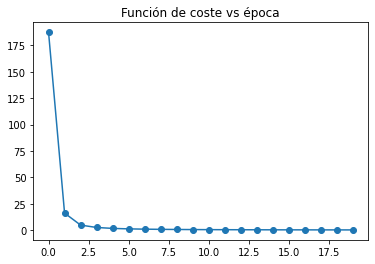

In [ ]:
plt.title("Función de coste vs época")
plt.plot(error,'-o')
plt.show();

# **Evaluación**

A continuación, evaluaremos cómo de bien se comporta nuestro perceptrón sobre el *dataset* de prueba. También trataremos de ver en profundidad qué regla ha aprendido para clasificar estos puntos.

## **Predicción**

Veamos cuán buena es nuestra neurona clasificando los puntos de prueba, con los que no ha sido entrenada y por tanto son nuevos para ella:

In [ ]:
pred_list = []
for (x, target) in zip(X_test, y_test):
    # hacemos un predicción y comprobamos
    pred = p.predict(x,addBias=True)
    print("dato={}, target={}, pred={}".format(
        x, target, pred))
    pred_list.append(pred)

dato=[-2.99804704  7.89466869], target=0, pred=0
dato=[-2.64765361  7.78998789], target=0, pred=0
dato=[3.93298627 2.82872534], target=1, pred=1
dato=[-2.52861723  8.71110635], target=0, pred=0
dato=[-2.49076369  9.36186783], target=0, pred=0
dato=[3.39416146 2.02810379], target=1, pred=1
dato=[4.9923838  1.40281832], target=1, pred=1
dato=[-3.73132543  9.72728456], target=0, pred=0
dato=[-2.22820576  8.39158661], target=0, pred=0
dato=[5.33870726 2.39414263], target=1, pred=1
dato=[-2.36831138  7.24584676], target=0, pred=0
dato=[2.73052275 3.29147201], target=1, pred=1
dato=[-1.4851351   9.60681308], target=0, pred=0
dato=[4.22805547 2.10509765], target=1, pred=1
dato=[-3.61490229  8.7993651 ], target=0, pred=0
dato=[-2.20036461 10.71650107], target=0, pred=0
dato=[-2.53671253 10.78653772], target=0, pred=0
dato=[-2.95926309  9.63713606], target=0, pred=0
dato=[4.80036846 4.18570072], target=1, pred=1
dato=[5.19302799 1.42496939], target=1, pred=1
dato=[2.11031876 1.67656222], target

Como vemos, nuestra neurona clasifica muy bien los puntos. Para medir cómo de bien, calculemos la *accuracy*:

In [ ]:
np.mean(y_test == pred_list)

1.0

El modelo es capaz de clasificar de forma perfecta todos los puntos de prueba. 

## **¿Qué ha aprendido?**

Dado que este caso es muy sencillo, podemos tratar de extraer la información aprendida en la matriz *W* y así construir la línea que el perceptrón está usando a la hora de separar las clases. En efecto, si tratamos de ver qué es *np.dot(X, self.W))* en la función *predict_proba* llegamos a que

$$W \cdot X = w_1 x_1 + w_2 x_2 + w_3.$$

Donde $x_1$ y $x_2$ son las dimensiones de nuestro punto X. $w_1,  w_2, w_3$ son los pesos calculados mediante *back propagation*, en particular $w_3$ es el bias. Así, nuestra neurona aprende a ajustar los pesos para que el producto anterior sea próximo a 1 o a 0 según el caso.

Para poder pasar a una clasificación binaria introdujimos un límite de discriminación que, como en todo problema logístico, establece el umbral a partir del cual la predicción numérica se considera como de una clase u otra. Teniendo esto en cuenta, es fácil de ver que la función *predict* establece:

$$ a(x) = \begin{cases}
1&\text{si $W \cdot X \gt limite$}\\
0&\text{si $W \cdot X \leq limite$}\\
\end{cases} $$

Por tanto, podemos trazar la frontera que separa a las dos clases como la línea:
$$ w_1 x_1 + w_2 x_2 + w_3 - limite = 0$$

De esta forma: 

$$ x_2 = - (w_1 x_1 + w_3 - limite) / w_2 $$


A continuación, se traza esta línea junto con los puntos del *dataset*:

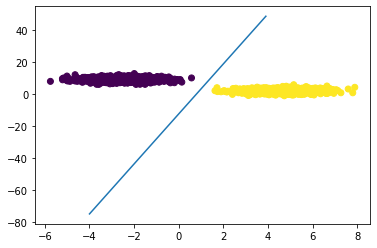

In [ ]:
plt.scatter(x=X[:,0], y=X[:,1], c=y)

x_range_axis = np.arange(-4, 4, 0.1)
limit = 0.5

#fórmula análoga a lo que hace el método predict 
y_range_axis = - (p.W[0] * x_range_axis + p.W[2] - limit) / p.W[1]

plt.plot(x_range_axis, y_range_axis)

plt.show()

La línea corta el plano, quedando todos los puntos de una case en un lado y todos los puntos de la otra clase al otro.

# **Conclusiones**

En este trabajo hemos creado un perceptrón y hemos puesto a prueba su capacidad de aprender a separar un conjunto de puntos repartido en dos clusters. Cada punto representaba un dato con dos parámetros independientes que identificamos como posiciones en un plano bidimensional. Además, cada punto contenía una etiqueta de clase, que tomaba dos valores posibles. El conjunto de puntos fue elegido de tal forma que fuese perfectamente separable en base a esta etiqueta mediante una línea.

A continuación, se entrenó el perceptrón con un subconjunto de datos del conjunto original y se validó con el conjunto remanente. Así, se inicializó de forma aleatoria y fue aprendiendo a clasificar los puntos. Para ello, fue calculando la función de coste definida como el error medio cuadrático para cada punto en varías etapas o iteraciones. Con esta información, trató de buscar el mínimo mediante el método Schtocastic Gradient Descend, ajustando los pesos del perceptrón para reducir el valor de la función de coste. Con cada iteración, observamos como el error disminuía.

Al haber trabajado con un conjunto de puntos perfectamente separable, nuestra neurona ha sido capaz de encontrar una separación entre ambos clusters, separando todos los puntos exitosamente. Se ha obtenido una *accuracy* del 100%. Además, se ha visualizado como todos los puntos quedan separados por la condición de la función *predict*.